In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
from functions import *
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

%matplotlib inline

In [37]:
data = pd.read_csv('D:/test/data1.csv')

In [38]:
data=data.rename(columns = {"Unnamed: 0": "Date"})
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace = True)
data.sort_index(inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143605 entries, 2020-01-01 00:05:00 to 2021-05-04 21:50:00
Data columns (total 2 columns):
Load      143605 non-null float64
N.Y.C.    143605 non-null float64
dtypes: float64(2)
memory usage: 3.3 MB


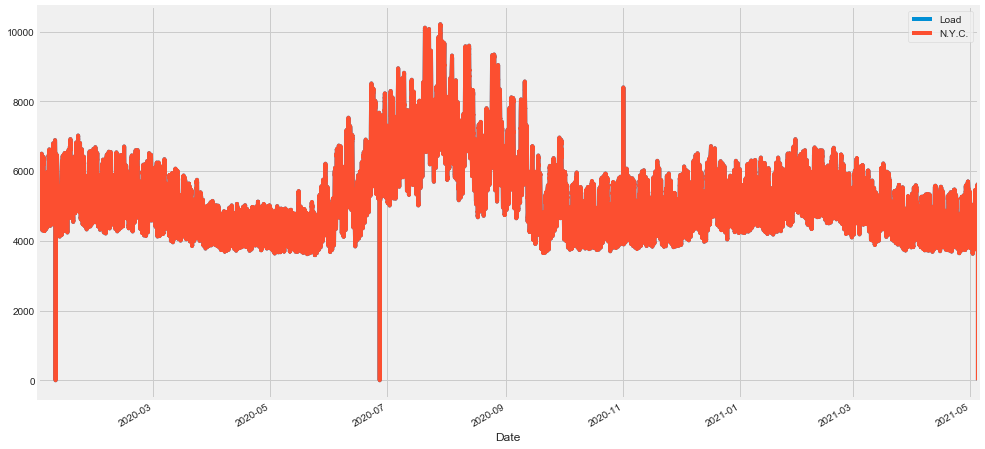

In [40]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [41]:
#drop NaNs
target = 'Load'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load      0
N.Y.C.    0
dtype: int64

In [42]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]
data.drop(drop_cols, axis=1, inplace=True)

In [43]:
data.head()

,Load
Date,
2020-01-01 00:05:00,4972.8
2020-01-01 00:10:00,4936.6
2020-01-01 00:15:00,4928.8
2020-01-01 00:20:00,4929.0
2020-01-01 00:25:00,4938.6


In [44]:
data.shape

(143605, 1)

In [45]:
# df = data['01-01-2014':'08-31-2019'].copy()

In [46]:
train, test = split_data(data, '01-01-2021')

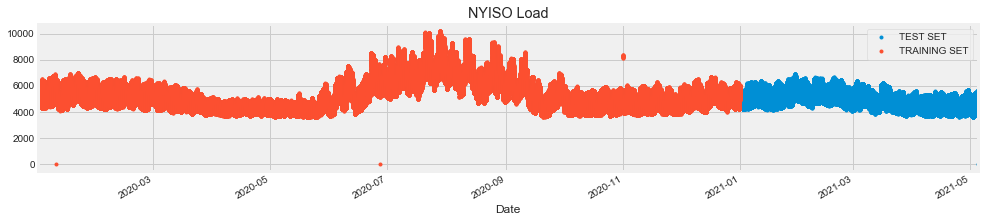

In [47]:
test \
    .rename(columns={target: 'TEST SET'}) \
    .join(train.rename(columns={target: 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,3), title='NYISO Load', style='.')

In [48]:
train = train.reset_index().rename(columns={'Date':'ds', target:'y'})
train.head()

,ds,y
0,2020-01-01 00:05:00,4972.8
1,2020-01-01 00:10:00,4936.6
2,2020-01-01 00:15:00,4928.8
3,2020-01-01 00:20:00,4929.0
4,2020-01-01 00:25:00,4938.6


In [49]:
# Setup and train model
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [50]:
test.head()

,Load
Date,
2021-01-01 00:00:00,4915.3086
2021-01-01 00:05:00,4892.8174
2021-01-01 00:10:00,4868.1533
2021-01-01 00:15:00,4856.5923
2021-01-01 00:20:00,4829.3720


In [51]:
test_=test.reset_index().rename(columns={'Date':'ds'})

In [52]:
test_['ds'].head()

0   2021-01-01 00:00:00
1   2021-01-01 00:05:00
2   2021-01-01 00:10:00
3   2021-01-01 00:15:00
4   2021-01-01 00:20:00
Name: ds, dtype: datetime64[ns]

In [53]:
test_fcst = model.predict(test_)

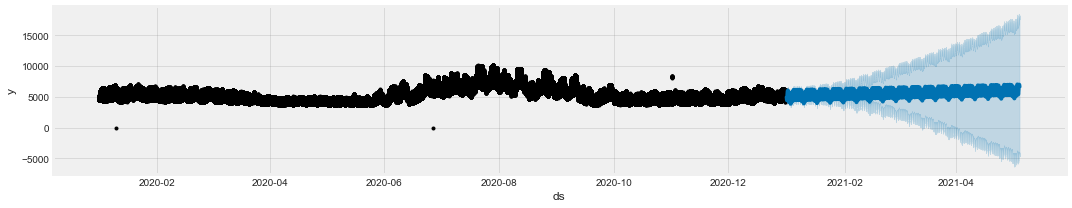

In [54]:
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(15)
fig = model.plot(test_fcst, ax=ax)

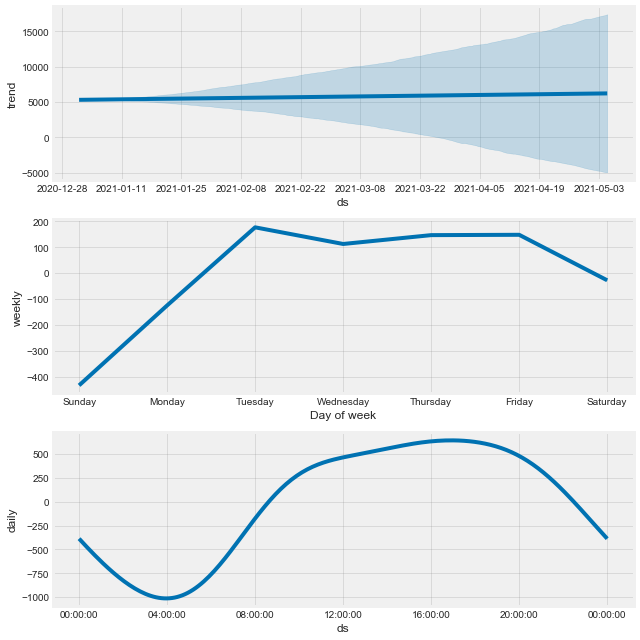

In [55]:
fig = model.plot_components(test_fcst)

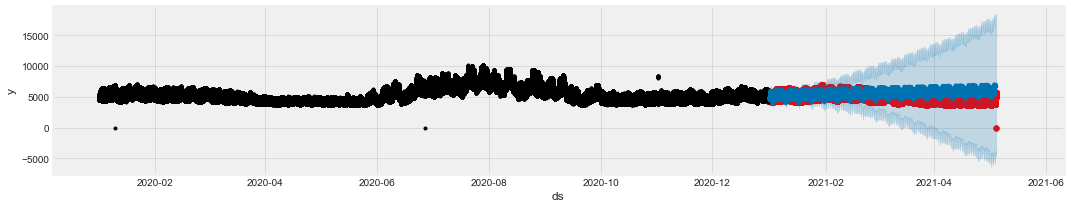

In [56]:
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)

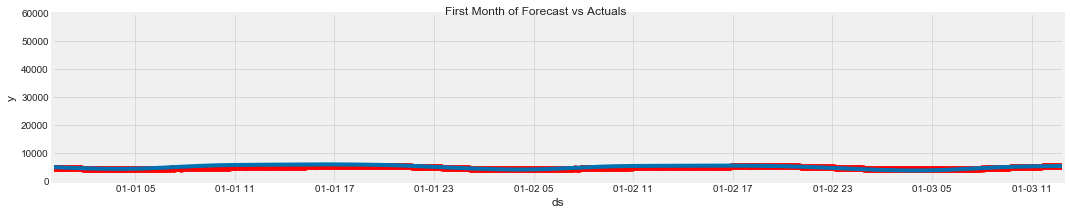

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24*31)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Month of Forecast vs Actuals')

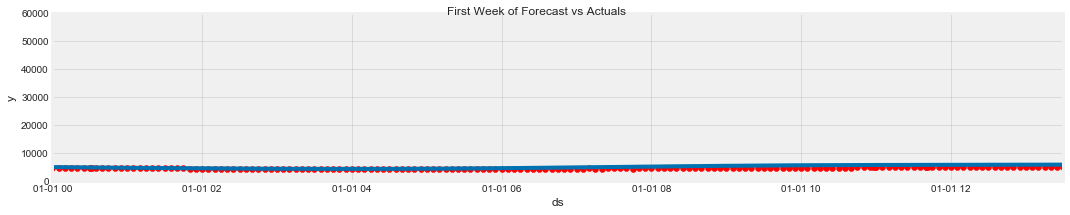

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24*7)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of Forecast vs Actuals')

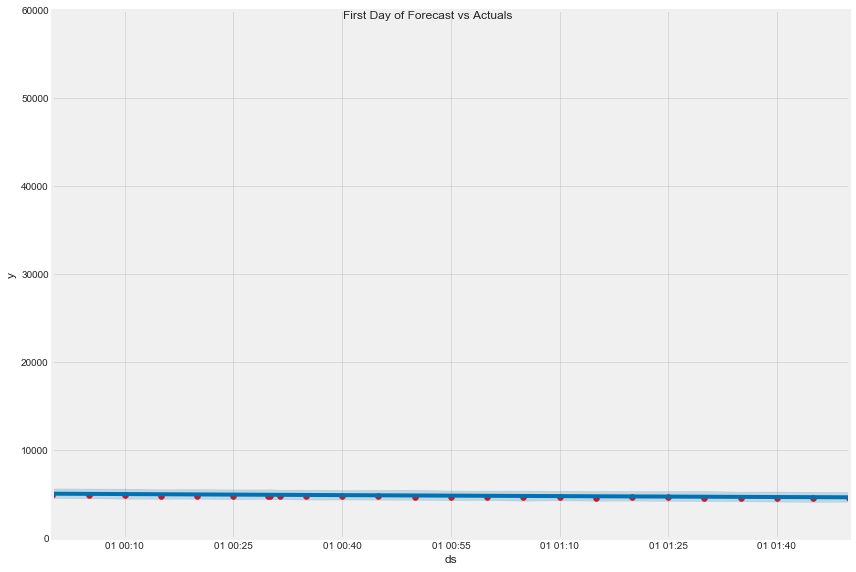

In [59]:
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(12)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Day of Forecast vs Actuals')

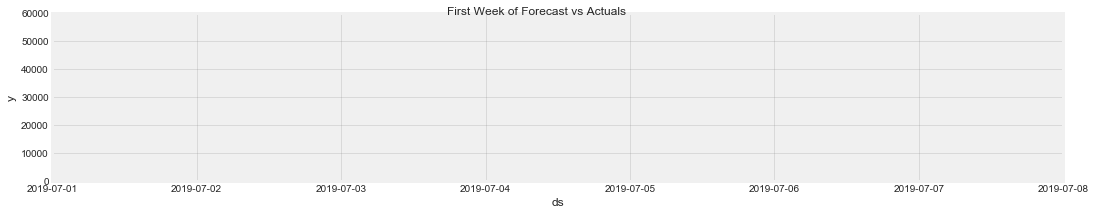

In [60]:
import datetime
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime(2019, 7, 1), upper=datetime.datetime(2019, 7, 8))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of Forecast vs Actuals')

In [61]:
mean_squared_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

823285.4396438493

In [62]:
mean_absolute_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

715.1970531972989

In [63]:
mean_absolute_percentage_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

inf

In [64]:
mean_absolute_percentage_error(y_true=test[:24][target],
                   y_pred=test_fcst[:24]['yhat'])

2.739726592644737

In [65]:
from numba import jit
import math

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [66]:
smape_fast(test[target],
                   test_fcst['yhat'])

13.32528658299777

In [67]:
smape_fast(test[:24][target],
                   test_fcst[:24]['yhat'])

2.701294754797976